# Introduction
The purpose of this notebook is twofold:
1. To show the strength of using the R 'forecast' package to do ARIMA models, since it not only has an auto.arima() function but ALSO because the forecast package has a fourier() function, which produces a fourier series from a time series with K number of terms that can be used as exogenous variables in the ARIMA function, as well as in the forecasts. This gives a leg up in flexibility for modeling longer term periodic/seasonal trends in a time series.
2. To examine the code behind these functions in order to create equivalent functions in python, so that it is not necessary to go back and forth between languages.

## Seeing the functions in action:

In [1]:
# importing packages
require(forecast)
require(data.table)

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: data.table



In [25]:
# loading the mean prices for all zipcodes from the zillow dataset, exported from python notebook
series <- fread('housing_means.csv')
series[1:5]

V1,mean price
<date>,<dbl>
1996-04-01,118299.1
1996-05-01,118419.0
1996-06-01,118537.4
1996-07-01,118653.1
1996-08-01,118780.3


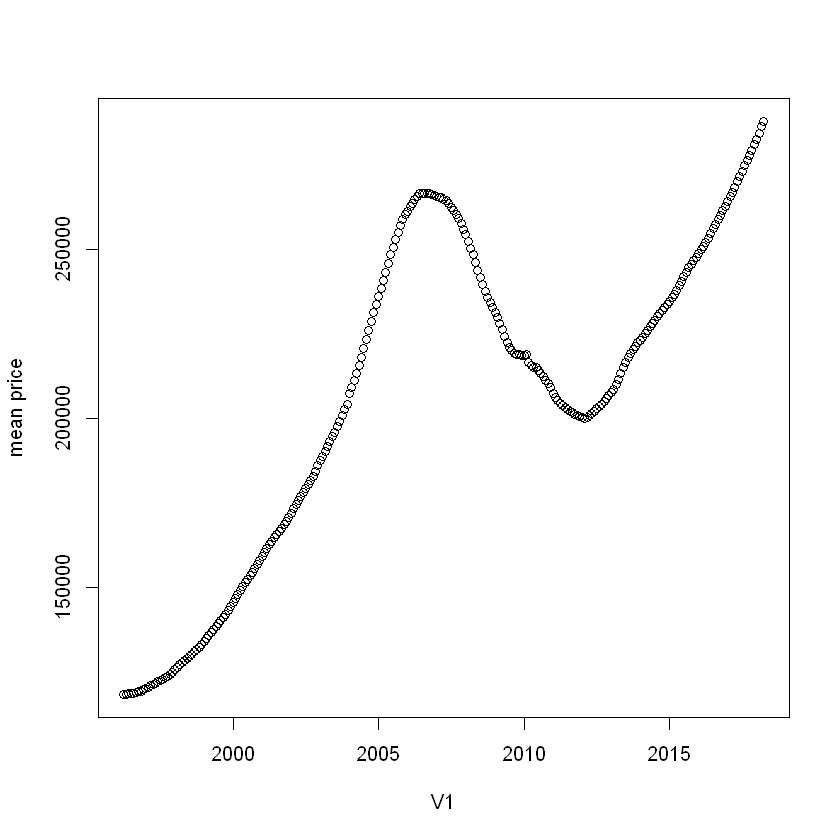

In [26]:
# visualizing data:
plot(series)

### Generating Periodogram:

In [27]:
library('GeneCycle')

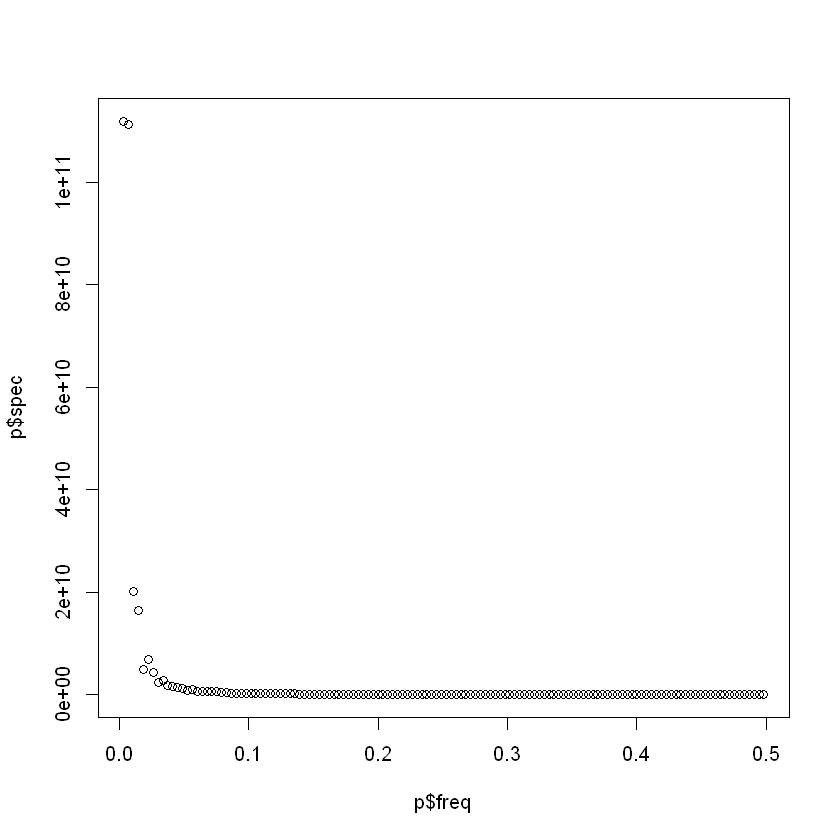

In [28]:
# Constructing periodogram to find frequencies of cycles
p <- periodogram(series$`mean price`)
plot(p$freq, p$spec)

In [29]:
# Finding the number of periods that correspond to the frequencies of the periodogram
data.table(period=1/p$freq, spec=p$spec)[order(-p$spec)][1:2]

period,spec.V1
<dbl>,<dbl>
265.0,111855779316
132.5,111310822179


In [30]:
# We can see that the periods found by the periodogram are the length of the series, and half
# the length of the series. The entire series does look like one cycle of a larger waveform, so 
# this makes sense, but it could also be an artifact of the way the periodogram works, I may need
# to compare this behavior to another dataset
NROW(series)

[1] 265

### Generating baseline model:

In [31]:
library(xts)

In [32]:
time_series = xts(x = series$`mean price`, order.by = as.Date(series$V1))
time_series[1:5]

               [,1]
1996-04-01 118299.1
1996-05-01 118419.0
1996-06-01 118537.4
1996-07-01 118653.1
1996-08-01 118780.3

In [33]:
model <- auto.arima(time_series, seasonal=TRUE)
model

Series: time_series 
ARIMA(0,2,1) 

Coefficients:
          ma1
      -0.2677
s.e.   0.0576

sigma^2 estimated as 76084:  log likelihood=-1850.54
AIC=3705.08   AICc=3705.12   BIC=3712.22

In [35]:
forecast(model, h=60)

    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
266       289699.1 289345.6 290052.6 289158.5 290239.8
267       291358.3 290651.3 292065.4 290277.0 292439.7
268       293017.5 291895.5 294139.5 291301.5 294733.5
269       294676.7 293084.2 296269.2 292241.2 297112.2
270       296335.9 294222.8 298448.9 293104.2 299567.5
271       297995.1 295315.5 300674.6 293897.0 302093.1
272       299654.3 296365.6 302942.9 294624.7 304683.8
273       301313.4 297375.9 305251.0 295291.4 307335.5
274       302972.6 298348.6 307596.7 295900.7 310044.5
275       304631.8 299285.7 309978.0 296455.6 312808.1
276       306291.0 300188.8 312393.2 296958.5 315623.5
277       307950.2 301059.4 314841.0 297411.7 318488.7
278       309609.4 301898.8 317319.9 297817.1 321401.6
279       311268.6 302708.2 319829.0 298176.6 324360.6
280       312927.8 303488.4 322367.1 298491.6 327363.9
281       314586.9 304240.6 324933.3 298763.6 330410.3
282       316246.1 304965.5 327526.8 298993.8 333498.4
283       

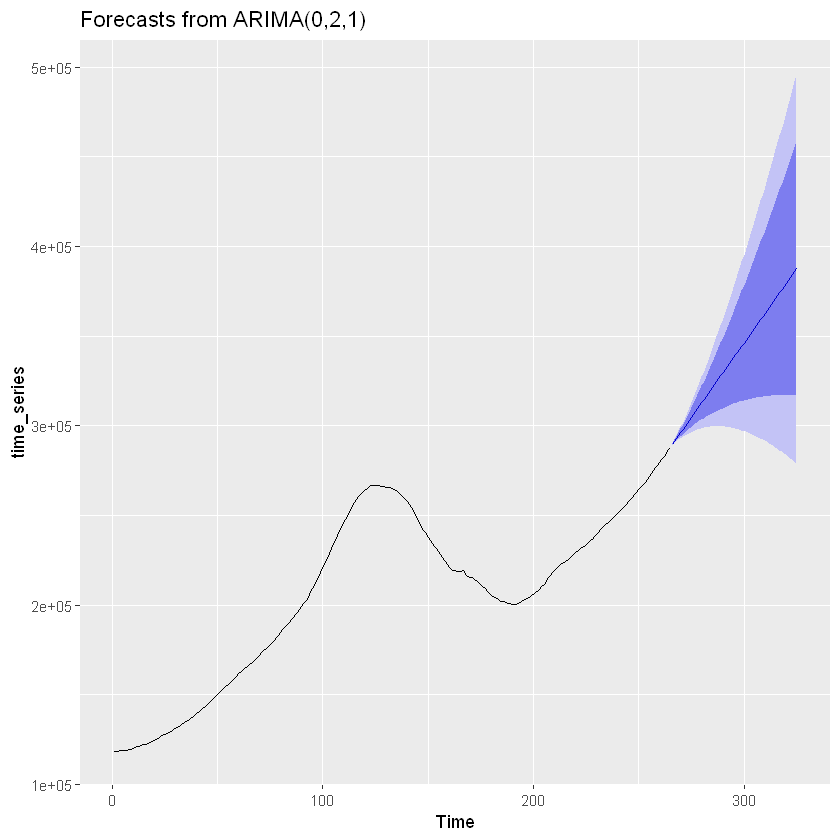

In [34]:
autoplot(forecast(model, h=60), geom = (12:6))

### Generating Model with Fourier terms:

In [39]:
# creating a sample fourier series from data:
fs = fourier(ts(time_series, f=132.5), K=2)

# We can see that sine and cosine values are generated for each value of K for each data point:
head(fs, 5)

S1-132,C1-132,S2-132,C2-132
0.04740250,0.9988759,0.09469842,0.9955060
0.09469842,0.9955060,0.18854569,0.9820644
0.14178144,0.9898980,0.28069832,0.9597960
0.18854569,0.9820644,0.37032803,0.9289010
0.23488605,0.9720229,0.45662924,0.8896571


In [42]:
length(fs)/4

[1] 265

In [43]:
# Looking at prediction behavior:
fs = fourier(ts(time_series, f=132.5), h=60, K=2)

# We can see that sine and cosine values are generated for each value of K for each data point:
head(fs, 5)

S1-132,C1-132,S2-132,C2-132
0.04740250,0.9988759,0.09469842,0.9955060
0.09469842,0.9955060,0.18854569,0.9820644
0.14178144,0.9898980,0.28069832,0.9597960
0.18854569,0.9820644,0.37032803,0.9289010
0.23488605,0.9720229,0.45662924,0.8896571


In [44]:
length(fs)/4

[1] 60

In [13]:
bestfit <- list(aicc=model$aicc, i=0, j=0, fit=model)
# Choose the best model by AICc
for(i in 1:7) {
  for (j in 1:7){
    z1 <- fourier(ts(time_series, frequency=265), K=i)
    z2 <- fourier(ts(time_series, frequency=132.5), K=j)
    print(c(i, j))
    fit <- auto.arima(time_series, xreg=cbind(z1, z2), seasonal=TRUE)
    if(fit$aicc < bestfit$aicc) {
        bestfit <- list(aicc=fit$aicc, i=i, j=j, fit=fit)
    }
  }
}
bestfit

[1] 1 1
[1] 1 2
[1] 1 3
[1] 1 4
[1] 1 5
[1] 1 6
[1] 1 7
[1] 2 1


ERROR: Error in auto.arima(time_series, xreg = cbind(z1, z2), seasonal = TRUE): xreg is rank deficient


In [14]:
# Looks like I will need to use exception handling with tryCatch()
bestfit <- list(aicc=model$aicc, i=0, j=0, fit=model)
# Choose the best model by AICc
min <- 0
min2 <- 0
for(i in min:7) {
  for (j in min2:7){
      possibleError <- tryCatch(
          {
              z1 <- fourier(ts(time_series, frequency=265), K=i)
              z2 <- fourier(ts(time_series, frequency=132.5), K=j)
              print(c(i, j))
              fit <- auto.arima(time_series, xreg=cbind(z1, z2), seasonal=TRUE)
              if(fit$aicc < bestfit$aicc) {
                  bestfit <- list(aicc=fit$aicc, i=i, j=j, fit=fit)
              }
          },
          error = function(cond){
              message(paste("i, j combo caused an error"))
          },
          warning = function(cond){
              message(paste("i, j combo caused a warning"))
          },
          finally={
          #message("Completed Optimization")
          }
    )
    if(inherits(possibleError, "error")) next
  }
}

[1] 0 0


i, j combo caused an error



[1] 0 1
[1] 0 2
[1] 0 3
[1] 0 4
[1] 0 5
[1] 0 6
[1] 0 7
[1] 1 0
[1] 1 1
[1] 1 2
[1] 1 3
[1] 1 4
[1] 1 5
[1] 1 6
[1] 1 7
[1] 2 0
[1] 2 1


i, j combo caused an error



[1] 2 2


i, j combo caused an error



[1] 2 3


i, j combo caused an error



[1] 2 4


i, j combo caused an error



[1] 2 5


i, j combo caused an error



[1] 2 6


i, j combo caused an error



[1] 2 7


i, j combo caused an error



[1] 3 0
[1] 3 1


i, j combo caused an error



[1] 3 2


i, j combo caused an error



[1] 3 3


i, j combo caused an error



[1] 3 4


i, j combo caused an error



[1] 3 5


i, j combo caused an error



[1] 3 6


i, j combo caused an error



[1] 3 7


i, j combo caused an error



[1] 4 0
[1] 4 1


i, j combo caused an error



[1] 4 2


i, j combo caused an error



[1] 4 3


i, j combo caused an error



[1] 4 4


i, j combo caused an error



[1] 4 5


i, j combo caused an error



[1] 4 6


i, j combo caused an error



[1] 4 7


i, j combo caused an error



[1] 5 0
[1] 5 1


i, j combo caused an error



[1] 5 2


i, j combo caused an error



[1] 5 3


i, j combo caused an error



[1] 5 4


i, j combo caused an error



[1] 5 5


i, j combo caused an error



[1] 5 6


i, j combo caused an error



[1] 5 7


i, j combo caused an error



[1] 6 0
[1] 6 1


i, j combo caused an error



[1] 6 2


i, j combo caused an error



[1] 6 3


i, j combo caused an error



[1] 6 4


i, j combo caused an error



[1] 6 5


i, j combo caused an error



[1] 6 6


i, j combo caused an error



[1] 6 7


i, j combo caused an error



[1] 7 0
[1] 7 1


i, j combo caused an error



[1] 7 2


i, j combo caused an error



[1] 7 3


i, j combo caused an error



[1] 7 4


i, j combo caused an error



[1] 7 5


i, j combo caused an error



[1] 7 6


i, j combo caused an error



[1] 7 7


i, j combo caused an error



In [15]:
bestfit

$aicc
[1] 3692.956

$i
[1] 5

$j
[1] 0

$fit
Series: time_series 
Regression with ARIMA(1,2,2) errors 

Coefficients:
         ar1      ma1    ma2     S1-265      C1-265     S2-265     C2-265
      0.7862  -1.2012  0.231  22871.000  -41865.724  -7250.962  18342.108
s.e.  0.0675   0.0936  0.085   6342.907    9686.324   2076.238   2751.943
        S3-265     C3-265      S4-265     C4-265    S5-265    C5-265
      1332.792  -7539.379  -1788.1240  2444.1207  2268.367   21.7208
s.e.  1184.533   1422.732    815.7834   923.6587   613.004  669.9788

sigma^2 estimated as 68923:  log likelihood=-1831.63
AIC=3691.26   AICc=3692.96   BIC=3741.27


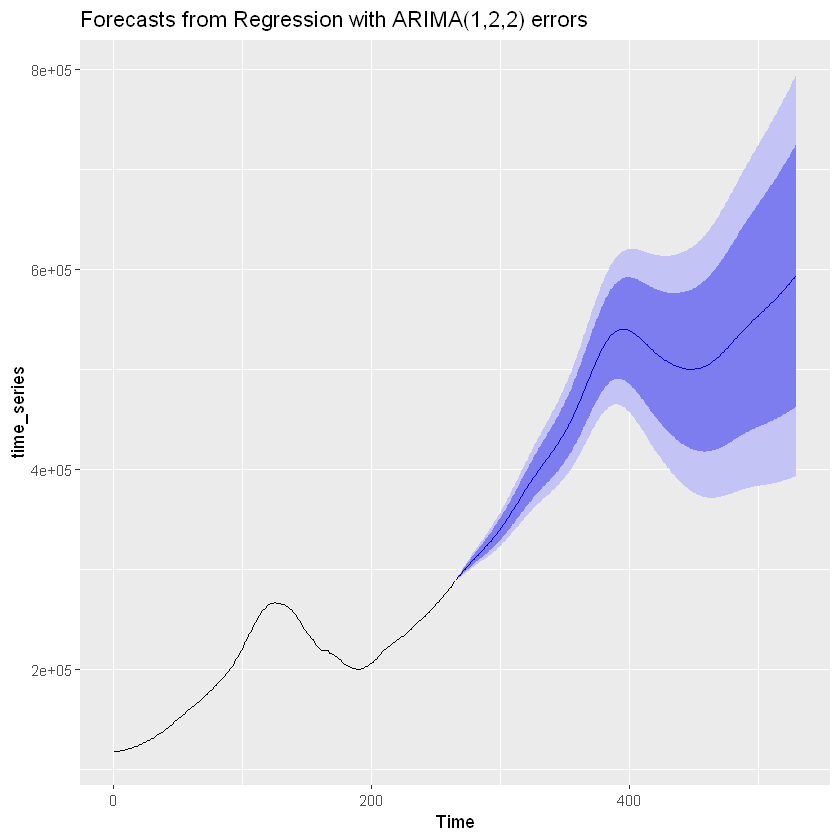

In [16]:
z1 <- fourier(ts(time_series, f=265), K=bestfit$i)
z2 <- fourier(ts(time_series, f=132,5), K=bestfit$j)
autoplot(forecast(bestfit$fit, h=60, xreg=cbind(z1, z2)))

Repeating the iterations using differenced time series rather than raw, to see if that makes a difference:

In [17]:
# Looks like I will need to use exception handling with tryCatch()
bestfit <- list(aicc=model$aicc, i=0, j=0, fit=model)
# Choose the best model by AICc
min <- 0
min2 <- 0
for(i in min:7) {
  for (j in min2:7){
      possibleError <- tryCatch(
          {
              z1 <- fourier(ts(diff(time_series, lag=2), frequency=265), K=i)
              z2 <- fourier(ts(diff(time_series, lag=2), frequency=132.5), K=j)
              print(c(i, j))
              fit <- auto.arima(time_series, xreg=cbind(z1, z2), seasonal=TRUE)
              if(fit$aicc < bestfit$aicc) {
                  bestfit <- list(aicc=fit$aicc, i=i, j=j, fit=fit)
              }
          },
          error = function(cond){
              message(paste("i, j combo caused an error"))
          },
          warning = function(cond){
              message(paste("i, j combo caused a warning"))
          },
          finally={
          #message("Completed Optimization")
          }
    )
    if(inherits(possibleError, "error")) next
  }
}

[1] 0 0


i, j combo caused an error



[1] 0 1
[1] 0 2
[1] 0 3
[1] 0 4
[1] 0 5
[1] 0 6
[1] 0 7
[1] 1 0
[1] 1 1
[1] 1 2
[1] 1 3
[1] 1 4
[1] 1 5
[1] 1 6
[1] 1 7
[1] 2 0
[1] 2 1


i, j combo caused an error



[1] 2 2


i, j combo caused an error



[1] 2 3


i, j combo caused an error



[1] 2 4


i, j combo caused an error



[1] 2 5


i, j combo caused an error



[1] 2 6


i, j combo caused an error



[1] 2 7


i, j combo caused an error



[1] 3 0
[1] 3 1


i, j combo caused an error



[1] 3 2


i, j combo caused an error



[1] 3 3


i, j combo caused an error



[1] 3 4


i, j combo caused an error



[1] 3 5


i, j combo caused an error



[1] 3 6


i, j combo caused an error



[1] 3 7


i, j combo caused an error



[1] 4 0
[1] 4 1


i, j combo caused an error



[1] 4 2


i, j combo caused an error



[1] 4 3


i, j combo caused an error



[1] 4 4


i, j combo caused an error



[1] 4 5


i, j combo caused an error



[1] 4 6


i, j combo caused an error



[1] 4 7


i, j combo caused an error



[1] 5 0
[1] 5 1


i, j combo caused an error



[1] 5 2


i, j combo caused an error



[1] 5 3


i, j combo caused an error



[1] 5 4


i, j combo caused an error



[1] 5 5


i, j combo caused an error



[1] 5 6


i, j combo caused an error



[1] 5 7


i, j combo caused an error



[1] 6 0
[1] 6 1


i, j combo caused an error



[1] 6 2


i, j combo caused an error



[1] 6 3


i, j combo caused an error



[1] 6 4


i, j combo caused an error



[1] 6 5


i, j combo caused an error



[1] 6 6


i, j combo caused an error



[1] 6 7


i, j combo caused an error



[1] 7 0
[1] 7 1


i, j combo caused an error



[1] 7 2


i, j combo caused an error



[1] 7 3


i, j combo caused an error



[1] 7 4


i, j combo caused an error



[1] 7 5


i, j combo caused an error



[1] 7 6


i, j combo caused an error



[1] 7 7


i, j combo caused an error



In [18]:
bestfit

$aicc
[1] 3692.956

$i
[1] 5

$j
[1] 0

$fit
Series: time_series 
Regression with ARIMA(1,2,2) errors 

Coefficients:
         ar1      ma1    ma2     S1-265      C1-265     S2-265     C2-265
      0.7862  -1.2012  0.231  22871.000  -41865.724  -7250.962  18342.108
s.e.  0.0675   0.0936  0.085   6342.907    9686.324   2076.238   2751.943
        S3-265     C3-265      S4-265     C4-265    S5-265    C5-265
      1332.792  -7539.379  -1788.1240  2444.1207  2268.367   21.7208
s.e.  1184.533   1422.732    815.7834   923.6587   613.004  669.9788

sigma^2 estimated as 68923:  log likelihood=-1831.63
AIC=3691.26   AICc=3692.96   BIC=3741.27


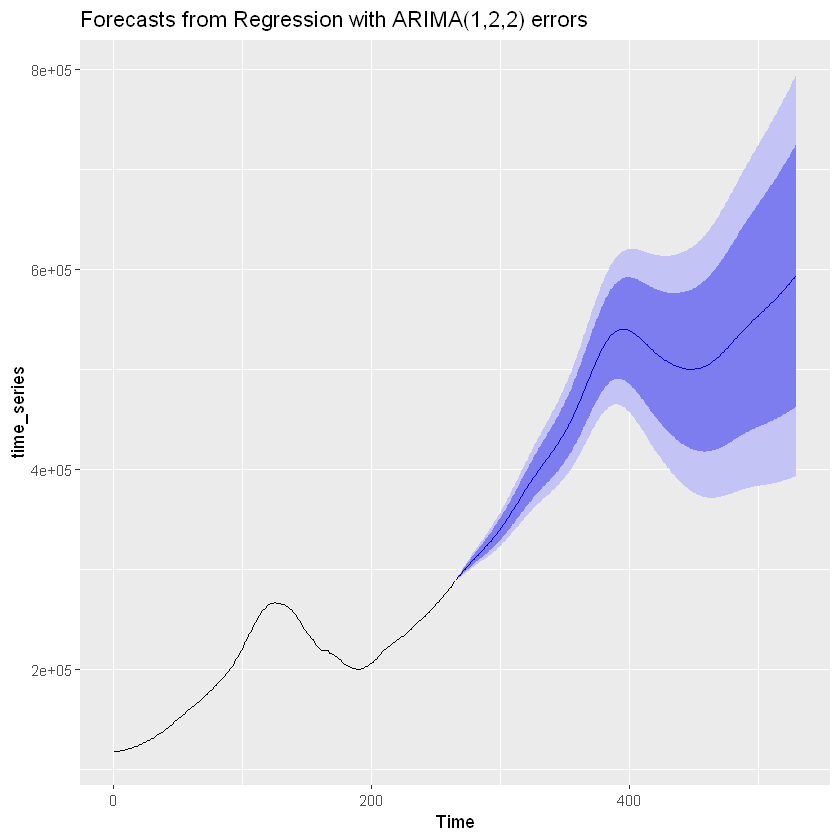

In [19]:
z1 <- fourier(ts(time_series, f=265), K=bestfit$i)
z2 <- fourier(ts(time_series, f=132,5), K=bestfit$j)
autoplot(forecast(bestfit$fit, h=60, xreg=cbind(z1, z2)))

In [20]:
# We can see that differencing the series before taking the fourier series did not have any
# effect.

### Notes so far:
We can see that adding the fourier terms has improved the AICC and log likelihood, but not dramatically. The BIC has actually increased. The forecasts are much more optimistic in the short term, and go a lot further out. It may be that with this dataset it is impossible to know whether there truly is a large seasonal cycle over the 20 years, because the cycle encompasses the entire dataset, and there is no opportunity for it to repeat itself. Visually, it does seem as though the periodicity would exist, but upon further thought, any sequence of data laid on it's own end multiple times would create its own seasonality. It looks as though this model has done exactly that, from the look of the predictions. <br>
<br>
It has occurred to me that any data might show a periodogram spike with a period the same length as the data, since if you lay the same pattern twice in a row it would create its own seasonality. Investigating this, I realize that I have made a big mistake in incorporating a seasonality of this description. Below, we will see that completely random data with a slight trend will show a strong spike on the periodogram at a frequency equal to the length of the data.

Warning message in seq(0, 400, by = 0.5) + rnorm(n = 800, mean = 0, sd = 200):
"longer object length is not a multiple of shorter object length"


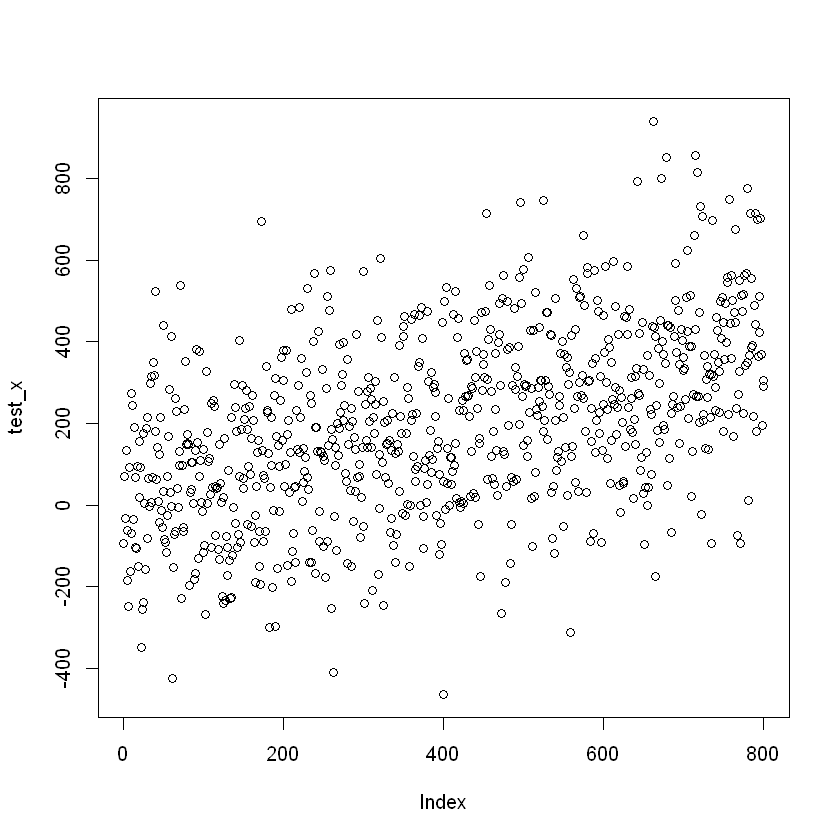

In [21]:
# Creating random data with a slight linear trend:
test_x <- seq(0, 400, by = .5) + rnorm(n = 800, mean = 0, sd = 200)
plot(test_x)

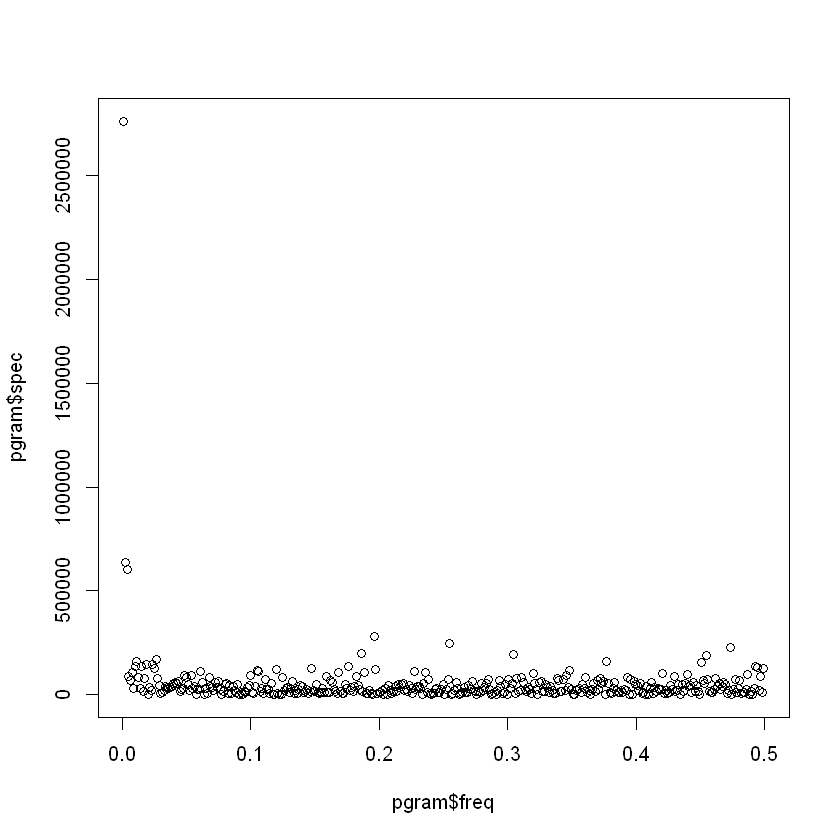

In [22]:
# Generate and plot periodogram
pgram <- periodogram(test_x)
plot(pgram$freq, pgram$spec)

In [23]:
# Check top 2 period
data.table(period=1/pgram$freq, spec=pgram$spec)[order(-pgram$spec)][1:3]

period,spec.V1
<dbl>,<dbl>
801.0,2763068.6
400.5,635615.2
267.0,604770.5


In [24]:
head(cbind(pgram$freq, pgram$spec), 3)

0.001248439,2763068.6
0.002496879,635615.2
0.003745318,604770.5


Here we can note that the full length of the data does indeed produce a spike on the periodogram. Also, the halfway point follows with the second highest value. This could mean that both of the frequencies used above to enhance the ARIMA model were just artifacts of the way a periodogram is generated. However, looking at the periodogram generated from the fully random data, the halfway spike is nowhere near as high relative to the full period spike as it is with the periodogram generated from the housing data, and it is also much further from the third. To see this, the latter is reproduced below:

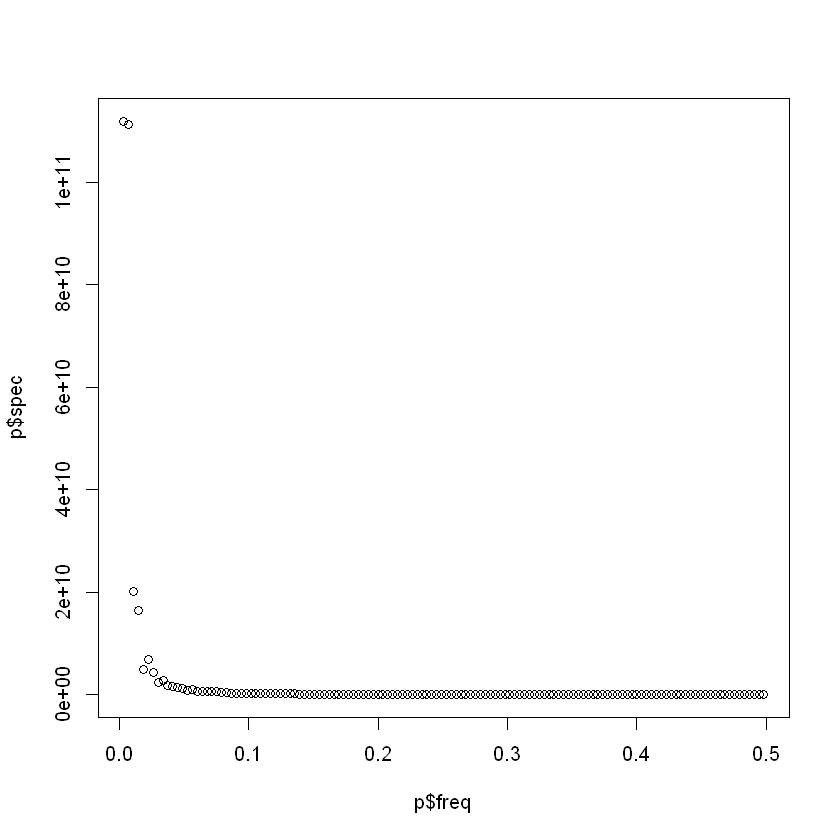

In [98]:
plot(p$freq, p$spec)

In [100]:
data.table(period=1/p$freq, spec=p$spec)[order(-p$spec)][1:2]

period,spec.V1
<dbl>,<dbl>
265.0,111855779316
132.5,111310822179


Here, rather than with the short dropoff to the second frequency seen with the random data, the second value is nearly as high as the first. This could mean that this spike presents more than just an artifact from the math, and could indeed be pointing to a seasonality worth consideration. Again, visually this seasonality does make sense, and housing markets do follow long term trends.<br>
<br>
Now to see how the model performs leaving out the full-length period used before, instead only using fourier series for the halfway point:

In [25]:
# Looks like I will need to use exception handling with tryCatch()
bestfit <- list(aicc=model$aicc, i=0, fit=model)
# Choose the best model by AICc
min <- 0
for(i in min:7) {
  possibleError <- tryCatch(
      {
          z1 <- fourier(ts(time_series, frequency=132.5), K=i)
          print(i)
          fit <- auto.arima(time_series, xreg=z1, seasonal=TRUE)
          if(fit$aicc < bestfit$aicc) {
              bestfit <- list(aicc=fit$aicc, i=i, fit=fit)
          }
      },
      error = function(cond){
          message(paste("i, j combo caused an error"))
      },
      warning = function(cond){
          message(paste("i, j combo caused a warning"))
      },
      finally={
      #message("Completed Optimization")
      }
  )
  if(inherits(possibleError, "error")) next

}

[1] 0


i, j combo caused an error



[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7


In [26]:
bestfit

$aicc
[1] 3703.386

$i
[1] 1

$fit
Series: time_series 
Regression with ARIMA(0,2,1) errors 

Coefficients:
          ma1     S1-132     C1-132
      -0.2943  -7167.379  17110.077
s.e.   0.0588   7424.949   7503.883

sigma^2 estimated as 74952:  log likelihood=-1847.62
AIC=3703.23   AICc=3703.39   BIC=3717.52


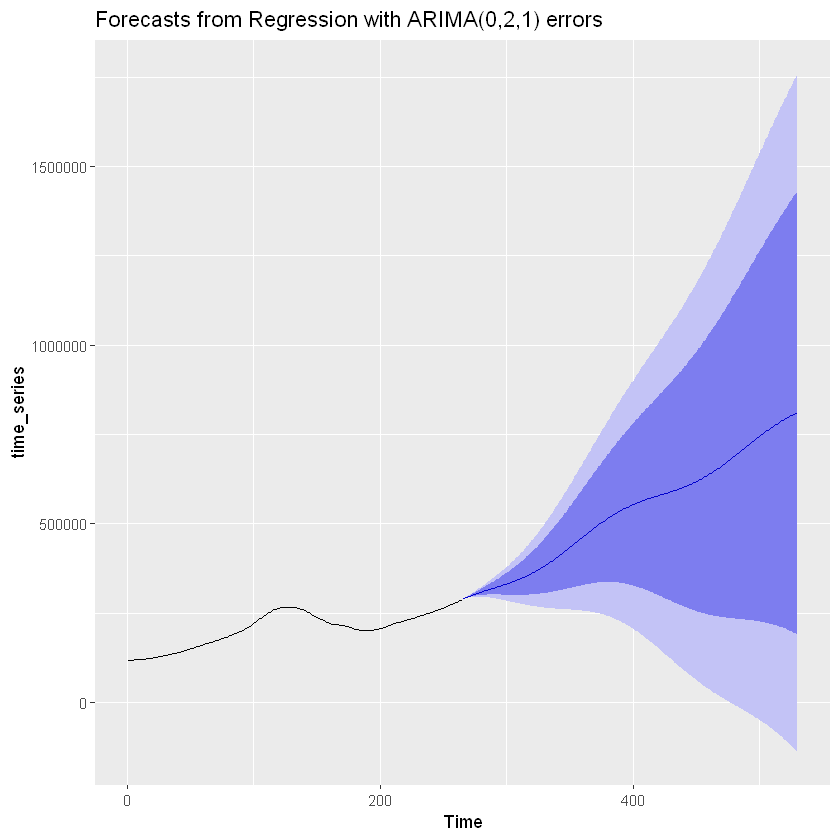

In [27]:
autoplot(forecast(bestfit$fit, h=60, xreg=fourier(ts(time_series, frequency=132.5), K=1)))

As we can see, this model is only the slightest bit better than the baseline model, though it does compete despite having more variables included. Limiting the size for better comparison:

In [28]:
install.packages('ggplot2')

Warning message:
"unable to access index for repository https://cran.r-project.org/src/contrib:
  cannot open URL 'https://cran.r-project.org/src/contrib/PACKAGES'"
Warning message:
"package 'ggplot2' is not available (for R version 4.0.2)"
Warning message:
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/4.0:
  cannot open URL 'https://cran.r-project.org/bin/windows/contrib/4.0/PACKAGES'"


In [29]:
library('ggplot2')

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



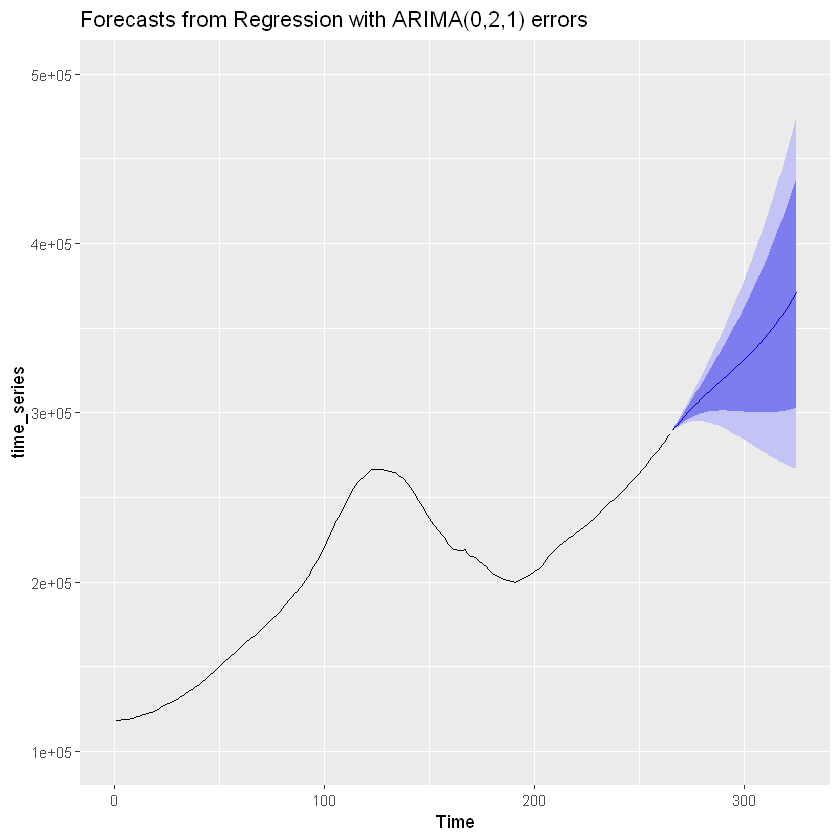

In [30]:
pt = autoplot(forecast(bestfit$fit, h=60, xreg=fourier(ts(time_series, frequency=132.5), K=1)), )
pt + xlim(0, 325) + ylim(100000, 500000)

We can see that these results are very similar to the baseline model, with the exception of a slight turn upward at the end of the projection period. A look below at a 10 year projection period:

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



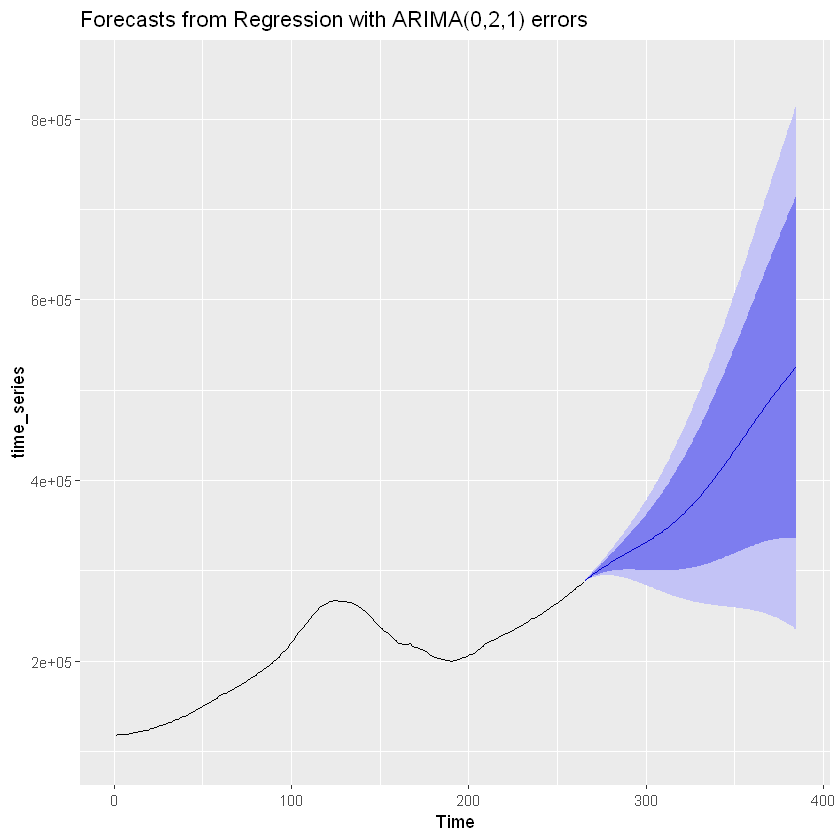

In [34]:
pt = autoplot(forecast(bestfit$fit, h=120, xreg=fourier(ts(time_series, frequency=132.5), K=1)), )
pt + xlim(0, 385) + ylim(100000, 850000)

We can see that these projections have a wide spread past the first few years. The 2007 housing crash may be too unique to try and treat as a seasonal event, so limiting the time window to the market after the crash levelled back off. Either way, the scope of this notebook was to investigate use of the Fourier series on the ARIMA models, which has so far given several insights, including into the full-period artifact of a periodogram.

## Looking at the function which produces Fourier series
The consideration here is to determine whether a python equivalent can be written to keep from switching languages on a regular basis. The R packages are very effective, so it may be that it's worth switching back and forth.<br>
<br>
Python already has equivalent functions to produce periodograms and ARIMA models, so the gap to bridge is the Fourier function.

In [35]:
forecast::fourier

function (x, K, h = NULL) 
{
    if (is.null(h)) {
        return(...fourier(x, K, 1:NROW(x)))
    }
    else {
        return(...fourier(x, K, NROW(x) + (1:h)))
    }
}
<bytecode: 0x000000002f1aea38>
<environment: namespace:forecast>

In [36]:
# Need to find ...fourier, can use getAnwyere
getAnywhere(...fourier)

A single object matching '...fourier' was found
It was found in the following places
  namespace:forecast
with value

function (x, K, times) 
{
    if (any(class(x) == "msts")) {
        period <- attr(x, "msts")
    }
    else {
        period <- frequency(x)
    }
    if (!exists("sinpi")) {
        sinpi <- function(x) {
            sin(pi * x)
        }
        cospi <- function(x) {
            cos(pi * x)
        }
    }
    if (length(period) != length(K)) {
        stop("Number of periods does not match number of orders")
    }
    if (any(2 * K > period)) {
        stop("K must be not be greater than period/2")
    }
    p <- numeric(0)
    labels <- character(0)
    for (j in seq_along(period)) {
        if (K[j] > 0) {
            p <- c(p, (1:K[j])/period[j])
            labels <- c(labels, paste(paste0(c("S", "C"), rep(1:K[j], 
                rep(2, K[j]))), round(period[j]), sep = "-"))
        }
    }
    k <- duplicated(p)
    p <- p[!k]
    labels <- labels[!rep(k, re

Testing outputs to understand function:

In [40]:
test_period <- frequency(ts(time_series, f=132.5))
test_period

[1] 132.5

In [41]:
seq_along(test_period)

[1] 1

In [42]:
length(test_period)

[1] 1

In [53]:
test_period[1]

[1] 132.5

In [50]:
# Investigating output of numeric(0)
numeric(0)

numeric(0)

In [51]:
# seems to have output nothing, checking output for numeric(1)
numeric(1)

[1] 0

In [52]:
# it seems as though this is a way to generate an empty numeric variable, testing below
zero <- numeric(0)
class(zero)

[1] "numeric"

In [55]:
# Looking into these lines, using a single K equal to 2
p <- numeric(0)
p <- c(p, (1:2)/test_period[1])
p

[1] 0.00754717 0.01509434

In [64]:
# investigating behavior of these lines
k <- duplicated(p)
k

[1] FALSE FALSE

In [65]:
# this appears to be filtering for any duplicated frequencies.
p <- p[!k]
p

[1] 0.00754717 0.01509434

In [ ]:
# We can see above that these lines are creating an array of cycles/unit of time, in this case
# cycles per month. With a period of 132.5 months, it is establishing the first and second
# harmonics, since K=2, seen by the fact that they are multiples of one another.
# For context, imagine a cycle that takes 10 seconds to complete, we would say the cycle is at
# 1cycle/10sec or .1 Hz. So above is 1cycle/132.5months

In [59]:
# Investigating these lines, which establish the list of labels:
K = 2
j = 1
period <- test_period
labels <- character(0)
labels <- c(labels, paste(paste0(c("S", "C"), rep(1:K[j], 
                rep(2, K[j]))), round(period[j]), sep = "-"))
labels

[1] "S1-132" "C1-132" "S2-132" "C2-132"

In [56]:
# the rep() function in r takes a value and repeats it a number of times
# the following will repeat 2 twice
rep(2,2)

[1] 2 2

In [63]:
rep(1:3, rep(2,3))

[1] 1 1 2 2 3 3

In [60]:
rep(1:2, rep(2, 2))

[1] 1 1 2 2

In [46]:
character(1)

[1] ""

Looking at the code, it looks transcribable. However, for now I'm just going to go back and forth to generate these values.

UPDATE: It has come to my attention that there is a way to import and execute R functions in python. Since there is only one function here that I am missing in python, it should be easy enough to do things this way, rather than switching back and forth or transcribing this function, which already works.

In [18]:
two_col <- cbind(time_series, time_series)
two_col

           time_series time_series.1
1996-05-01   119.92108     119.92108
1996-06-01   118.37913     118.37913
1996-07-01   115.64601     115.64601
1996-08-01   127.18503     127.18503
1996-09-01   147.27419     147.27419
1996-10-01   192.99182     192.99182
1996-11-01   224.83192     224.83192
1996-12-01   339.73253     339.73253
1997-01-01   436.18094     436.18094
1997-02-01   422.97574     422.97574
1997-03-01   352.38234     352.38234
1997-04-01   371.55072     371.55072
1997-05-01   387.72289     387.72289
1997-06-01   397.20842     397.20842
1997-07-01   403.23324     403.23324
1997-08-01   423.58787     423.58787
1997-09-01   447.47534     447.47534
1997-10-01   495.70332     495.70332
1997-11-01   530.63208     530.63208
1997-12-01   648.86372     648.86372
1998-01-01   734.06844     734.06844
1998-02-01   714.10828     714.10828
1998-03-01   635.47892     635.47892
1998-04-01   650.10594     650.10594
1998-05-01   648.65201     648.65201
1998-06-01   647.68759     647.68759
1

In [19]:
fourier(ts(time_series, f=c(132.5, 265)), K=c(1,1))

Warning message in if (start > end) stop("'start' cannot be after 'end'"):
"the condition has length > 1 and only the first element will be used"
Warning message in if (abs(round(cycles) - cycles) > ts.eps * max(cycles, 1)) stop("'end' must be a whole number of cycles after 'start'"):
"the condition has length > 1 and only the first element will be used"
Warning message in if (nobs != ndata) data <- if (NCOL(data) == 1) {:
"the condition has length > 1 and only the first element will be used"


ERROR: Error in attr(data, "tsp") <- c(start, end, frequency): 'tsp' attribute must be numeric of length three


In [20]:
ts(time_series, f=c(132.5, 265))

Warning message in if (start > end) stop("'start' cannot be after 'end'"):
"the condition has length > 1 and only the first element will be used"
Warning message in if (abs(round(cycles) - cycles) > ts.eps * max(cycles, 1)) stop("'end' must be a whole number of cycles after 'start'"):
"the condition has length > 1 and only the first element will be used"
Warning message in if (nobs != ndata) data <- if (NCOL(data) == 1) {:
"the condition has length > 1 and only the first element will be used"


ERROR: Error in attr(data, "tsp") <- c(start, end, frequency): 'tsp' attribute must be numeric of length three
